# Stock Analysis Using LSTM - MVP
This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [1]:
import pandas as pd
import numpy as np
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [2]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [3]:
# switches
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
# switch to control whether Colab-specific items are run
on_colab = config['general']['on_colab']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
# e.g. company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']
saved_model_modifier = config['files']['saved_model_modifier']

In [4]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

In [6]:
# ingest config parameters

In [7]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'master_start': '2018-01-01'},
 'files': {'saved_model_modifier': 'January272021'},
 'tech_list': ['CROX', 'SHAK', 'KWR'],
 'company_dict': {'CROX': 'Crocs',
  'SHAK': 'Shake Shack',
  'KWR': 'Quaker Chemical Corp.'},
 'test_parms': {'testproportion': 0.2,
  'trainproportion': 0.8,
  'current_experiment': 5,
  'repeatable_run': False,
  'get_test_train_acc': True},
 'categorical': ['neighbourhood_grou

In [8]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-31,80.669998,77.072502,80.232498,77.377502,199588400.0,76.714989
2020-02-03,78.372498,75.555000,76.074997,77.165001,173985600.0,76.504311
2020-02-04,79.910004,78.407501,78.827499,79.712502,136616400.0,79.029999
2020-02-05,81.190002,79.737503,80.879997,80.362503,118826800.0,79.674438
2020-02-06,81.305000,80.065002,80.642502,81.302498,105425600.0,80.606384


In [9]:
# The tech stocks used for this analysis
#tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
#company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

stock_dict = {}
#For loop for grabing yahoo finance data and setting as a dataframe
# TODO correct use of globals() here
seeded = False
for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    stock_dict[stock] = DataReader(stock, 'yahoo', start, end)
    # add column for company name
    stock_dict[stock]['company_name'] = company_dict[stock]
    # build up overall dataframe containing stock info for all companies
    if seeded:
        df = pd.concat([df,stock_dict[stock]],axis=0)
    else:
        seeded = True
        df = stock_dict[stock]
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2021-01-15,279.059998,270.350006,274.940002,271.269989,64100.0,271.269989,Quaker Chemical Corp.
2021-01-19,278.570007,273.059998,275.450012,274.720001,70300.0,274.720001,Quaker Chemical Corp.
2021-01-20,277.519989,272.359985,276.920013,275.799988,55700.0,275.799988,Quaker Chemical Corp.
2021-01-21,279.720001,268.410004,276.839996,269.059998,55100.0,269.059998,Quaker Chemical Corp.
2021-01-22,277.160004,263.799988,265.019989,273.899994,57700.0,273.899994,Quaker Chemical Corp.
2021-01-25,274.429993,268.559998,271.559998,271.609985,59400.0,271.609985,Quaker Chemical Corp.
2021-01-26,274.329987,268.940002,271.350006,269.299988,74400.0,269.299988,Quaker Chemical Corp.
2021-01-27,280.769989,261.109985,263.600006,275.320007,130300.0,275.320007,Quaker Chemical Corp.
2021-01-28,280.850006,267.339996,276.500000,272.959991,71600.0,272.959991,Quaker Chemical Corp.


In [10]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-01-31,39.290001,37.759998,39.169998,37.910000,824100.0,37.910000,Crocs
2020-02-03,38.180000,37.349998,37.880001,37.490002,1102100.0,37.490002,Crocs
2020-02-04,39.779999,38.160000,38.230000,38.840000,869100.0,38.840000,Crocs
2020-02-05,39.709999,38.689999,39.090000,39.410000,490200.0,39.410000,Crocs
2020-02-06,39.750000,39.090000,39.439999,39.169998,337800.0,39.169998,Crocs


Let's go ahead and play aorund with the AAPL DataFrame to get a feel for the data

# Create dataframe

In [11]:
# Summary Stats
#stock_dict['AAPL'].describe()

In [12]:
# General info
#stock_dict['AAPL'].info()

In [13]:
# Let's see a historical view of the closing price

if plot_all:
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        stock_dict[company]['Adj Close'].plot()
        plt.ylabel('Adj Close')
        plt.xlabel(None)
        plt.title(f"{tech_list[i - 1]}")

In [14]:
# Now let's plot the total volume of stock being traded each day
if plot_all:
    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        stock_dict[company]['Volume'].plot()
        plt.ylabel('Volume')
        plt.xlabel(None)
        plt.title(f"{tech_list[i - 1]}")

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

In [15]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in tech_list:
        column_name = f"MA for {ma} days"
        stock_dict[company][column_name] = stock_dict[company]['Adj Close'].rolling(ma).mean()

In [16]:
#print(stock_dict['GOOG'].columns)

Now let's go ahead and plot all the additional Moving Averages

In [17]:
if plot_all:
    df.groupby("company_name").hist(figsize=(12, 12));

In [18]:
if plot_all:
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(8)
    fig.set_figwidth(15)

    AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
    axes[0,0].set_title('APPLE')

    GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
    axes[0,1].set_title('GOOGLE')

    MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
    axes[1,0].set_title('MICROSOFT')

    AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
    axes[1,1].set_title('AMAZON')

    fig.tight_layout()

# 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

In [19]:
if plot_all:
    # We'll use pct_change to find the percent change for each day
    for company in tech_list:
        stock_dict[company]['Daily Return'] = stock_dict[company]['Adj Close'].pct_change()

    # Then we'll plot the daily return percentage
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(8)
    fig.set_figwidth(15)

    stock_dict['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
    axes[0,0].set_title('APPLE')

    stock_dict['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
    axes[0,1].set_title('GOOGLE')

    stock_dict['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
    axes[1,0].set_title('MICROSOFT')

    stock_dict['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
    axes[1,1].set_title('AMAZON')

    fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

In [20]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
if plot_all:
    plt.figure(figsize=(12, 12))

    for i, company in enumerate(tech_list, 1):
        plt.subplot(2, 2, i)
        sns.distplot(stock_dict[company]['Daily Return'].dropna(), bins=100, color='purple')
        plt.ylabel('Daily Return')
        plt.title(company_dict[company])
    # Could have also done:
    #AAPL['Daily Return'].hist()

# 4. What was the correlation between different stocks closing prices?

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [21]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols,CROX,SHAK,KWR
Date,,,
2020-01-31,37.910000,67.449997,164.677582
2020-02-03,37.490002,68.239998,166.591980
2020-02-04,38.840000,69.849998,173.247742
2020-02-05,39.410000,70.900002,178.008911
2020-02-06,39.169998,73.320000,177.532791


Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did for the Apple stock.

In [22]:
# Make a new tech returns DataFrame
# pct_change() https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html
# Percentage change between the current and a prior element.
# Computes the percentage change from the immediately previous row by default. This is useful in comparing the percentage of change in a time series of elements.
tech_rets = closing_df.pct_change()
# note that first row is NaN because there is no predecessor for the first row
tech_rets.head()

Symbols,CROX,SHAK,KWR
Date,,,
2020-01-31,NaN,NaN,NaN
2020-02-03,-0.011079,0.011712,0.011625
2020-02-04,0.036010,0.023593,0.039952
2020-02-05,0.014676,0.015032,0.027482
2020-02-06,-0.006090,0.034133,-0.002675


Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

In [23]:
# Comparing Google to itself should show a perfectly linear relationship
if plot_all:
    sns.jointplot('GOOG', 'GOOG', tech_rets, kind='scatter', color='seagreen')

In [24]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
if plot_all:
    sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur. 

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

In [25]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons
if plot_all:
    sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison. While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

In [26]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
if plot_all:
    return_fig = sns.PairGrid(tech_rets.dropna())

    # Using map_upper we can specify what the upper triangle will look like.
    return_fig.map_upper(plt.scatter, color='purple')

    # We can also define the lower triangle in the figure, inclufing the plot type (kde) 
    # or the color map (BluePurple)
    return_fig.map_lower(sns.kdeplot, cmap='cool_d')

    # Finally we'll define the diagonal as a series of histogram plots of the daily return
    return_fig.map_diag(plt.hist, bins=30)

In [27]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
if plot_all:
    returns_fig = sns.PairGrid(closing_df)

    # Using map_upper we can specify what the upper triangle will look like.
    returns_fig.map_upper(plt.scatter,color='purple')

    # We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
    returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

    # Finally we'll define the diagonal as a series of histogram plots of the daily return
    returns_fig.map_diag(plt.hist,bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

In [28]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
if plot_all:
    sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

In [29]:
if plot_all:
    sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

Fantastic! Just like we suspected in our PairPlot we see here numerically and visually that Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

In [30]:
# Let's start by defining a new DataFrame as a cleaned version of the orignal tech_rets DataFrame
rets = tech_rets.dropna()
if plot_all:
    area = np.pi*20

    plt.figure(figsize=(12, 10))
    plt.scatter(rets.mean(), rets.std(), s=area)
    plt.xlabel('Expected return')
    plt.ylabel('Risk')

    for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
        plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                     arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# 6. Predicting the closing price stock price of APPLE inc:

In [31]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# start='2012-01-01'
for company in tech_list:
    df_predict[company] = DataReader(company,data_source='yahoo', start=config['general']['master_start'], end=datetime.now())
#df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
#Show teh data
#df_predict['AAPL']

In [32]:
if plot_all:
    plt.figure(figsize=(12, 12))
    #plt.title('Close Price History')
    for i, company in enumerate(tech_list,1):
        plt.subplot(2,2,i)
        plt.plot(df_predict[company]['Close'])
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.title(company_dict[company])
        #plt.show()
    


In [33]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [34]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [35]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [36]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [37]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [38]:
def create_x_y(scaled_data,training_data_len):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if (i<= 61) and plot_all:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [39]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
for company in tech_list:
    data[company],dataset,training_data_len = one_col_df(df_predict[company],'Close')
    scaled_data, scaler = scale_data(dataset)
    x_train, y_train = create_x_y(scaled_data,training_data_len)
    print("TRAINING LOOP FOR: ",str(company))
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    test_data = scaled_data[training_data_len - 60: , :]
    #Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    predictions[company] = scaler.inverse_transform(predictions_temp)

TRAINING LOOP FOR:  CROX
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
560/560 [==============================] - 32s 57ms/step - loss: 0.0015
Saved model with name  CROXJanuary312021.h5
TRAINING LOOP FOR:  SHAK
Epoch 1/1
560/560 [==============================] - 31s 56ms/step - loss: 0.0035
Saved model with name  SHAKJanuary312021.h5
TRAINING LOOP FOR:  KWR
Epoch 1/1
560/560 [==============================] - 32s 57ms/step - loss: 0.0050
Saved model with name  KWRJanuary312021.h5
Wall time: 1min 46s


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


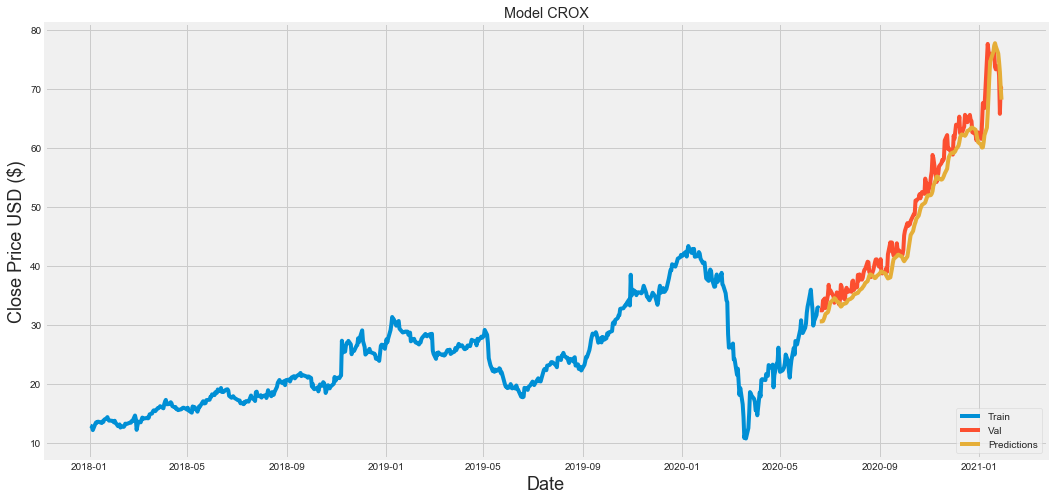

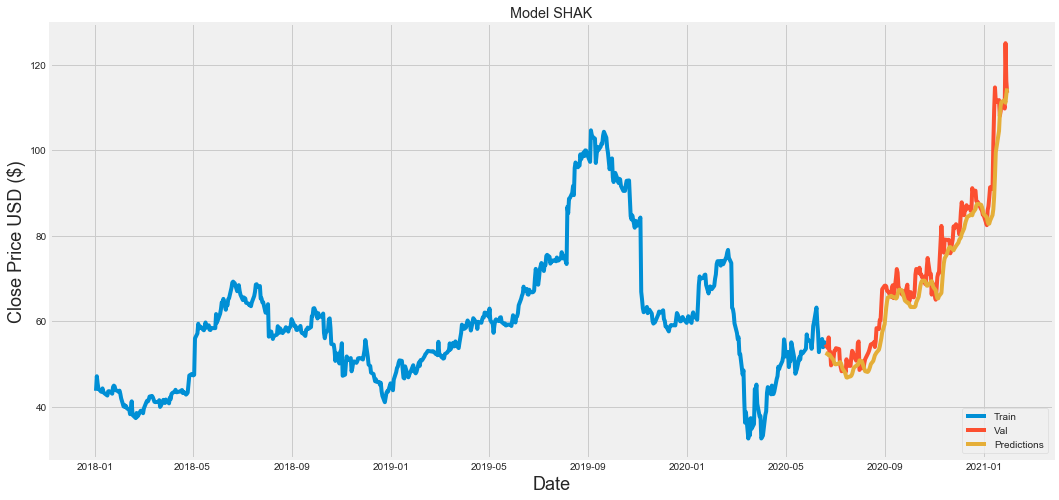

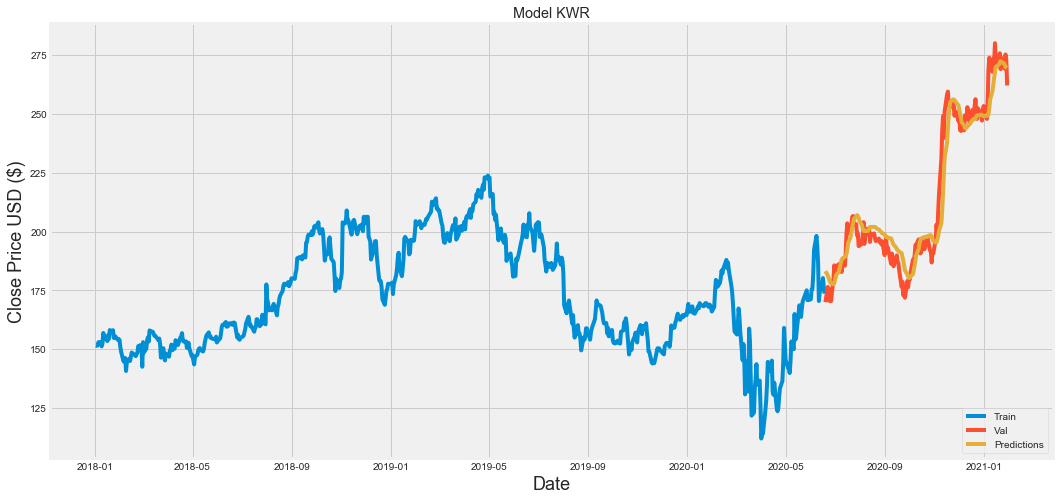

In [40]:
# Plot the data
for company in tech_list:
    train = data[company][:training_data_len]
    valid = data[company][training_data_len:]
    valid['Predictions'] = predictions[company]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [41]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-06-19,169.979996,183.180557
2020-06-22,176.440002,181.322845
2020-06-23,173.179993,180.224670
2020-06-24,170.559998,179.323471
2020-06-25,175.339996,178.381332
...,...,...
2021-01-25,271.609985,271.596313
2021-01-26,269.299988,270.974579
2021-01-27,275.320007,270.018982
